# Clustering

Setup environment <br>
Import relevant libraries

In [1]:
from bigdata_a3_utils import *
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os, pickle, gc

## Load Categories

In [2]:
def get_needed_cols(base_path, category):
    #columns we want
    needed= ['parent_asin', 'rating', 'brand', 'main_category']
    #read in pickle file
    print(f"Reading in {category} data")
    df= pd.read_pickle(base_path / f"cleaned_data_{category}.pkl")
    print(f"Finished reading in {category} data")
    
    columns_to_drop = df.columns.difference(needed)
    df.drop(columns=columns_to_drop, inplace=True)
    print("Dropped unneeded columns")
    gc.collect()
    return df

In [3]:
base_path= Path(r"F:\Saeed\frames")

dfs = []

for category in VALID_CATEGORIES:
    x = get_needed_cols(base_path, category)
    dfs.append(x)
    gc.collect()

df = pd.concat(dfs, ignore_index=True)

Reading in All_Beauty data
Finished reading in All_Beauty data
Dropped unneeded columns
Reading in Amazon_Fashion data
Finished reading in Amazon_Fashion data
Dropped unneeded columns
Reading in Appliances data
Finished reading in Appliances data
Dropped unneeded columns
Reading in Arts_Crafts_and_Sewing data
Finished reading in Arts_Crafts_and_Sewing data
Dropped unneeded columns
Reading in Automotive data
Finished reading in Automotive data
Dropped unneeded columns
Reading in Baby_Products data
Finished reading in Baby_Products data
Dropped unneeded columns
Reading in Beauty_and_Personal_Care data
Finished reading in Beauty_and_Personal_Care data
Dropped unneeded columns
Reading in Books data
Finished reading in Books data
Dropped unneeded columns
Reading in CDs_and_Vinyl data
Finished reading in CDs_and_Vinyl data
Dropped unneeded columns
Reading in Cell_Phones_and_Accessories data
Finished reading in Cell_Phones_and_Accessories data
Dropped unneeded columns
Reading in Clothing_Shoe

## Features

Category id map

In [4]:
category_map = {
    'all beauty': 0,
    'amazon fashion': 1,
    'appliances': 2,
    'arts, crafts and sewing': 3,
    'automotive': 4,
    'baby products': 5,
    'beauty and personal care': 6,
    'books': 7,
    'cds and vinyl': 8,
    'cell phones and accessories': 9,
    'clothing shoes and jewelry': 10,
    'digital music': 11,
    'electronics': 12,
    'gift cards': 13,
    'grocery and gourmet food': 14,
    'handmade products': 15,
    'health and household': 16,
    'health and personal care': 17,
    'home and kitchen': 18,
    'industrial and scientific': 19,
    'kindle store': 20,
    'magazine subscriptions': 21,
    'movies and tv': 22,
    'musical instruments': 23,
    'office products': 24,
    'patio lawn and garden': 25,
    'pet supplies': 26,
    'software': 27,
    'sports and outdoors': 28,
    'subscription boxes': 29,
    'tools and home improvement': 30,
    'toys and games': 31,
    'video games': 32,
    'unknown': 33
}

Feature engineering

In [5]:
# Compute mean rating and total reviews for products
product_df = df.groupby('parent_asin').agg(
    mean_rating=('rating', 'mean'),
    total_reviews=('rating', 'count'),
    brand=('brand', lambda x: x.iloc[0]),
    main_category=('main_category', lambda x: x.iloc[0]),
).reset_index()

# Delete df to free up memory
del df
gc.collect()

# Encode categorical features, brand and main_category
print(f"Encoding categorical features...")
product_df['brand'] = product_df['brand'].fillna('Unknown')
product_df['main_category'] = product_df['main_category'].fillna('Unknown')

# Map category IDs
product_df['main_category'] = product_df['main_category'].str.replace('&', 'and').str.lower()
product_df['category_id'] = product_df['main_category'].map(category_map).fillna(33).astype(int)

# Apply label encoding 
encoder_brand = LabelEncoder()
product_df['brand'] = product_df['brand'].str.lower()
product_df['brand_id'] = encoder_brand.fit_transform(product_df['brand'])

# Prepare matrix
product_df = product_df[['parent_asin', 'mean_rating', 'total_reviews', 'brand_id', 'category_id']]
features = product_df[['mean_rating', 'total_reviews', 'brand_id', 'category_id']]

product_df.head()


Encoding categorical features...


,parent_asin,mean_rating,total_reviews,brand_id,category_id
0,0000000116,2.5,2,4320979,7
1,0000002488,2.0,1,1477294,7
2,0000004545,5.0,1,586020,7
3,0000005371,5.0,1,1329367,7
4,0000012297,1.0,1,516396,7


## k-means

In [6]:
# Apply KMeans clustering
print(f"Applying KMeans clustering...")
kmeans = KMeans(n_clusters=5, random_state=42)
product_df['cluster'] = kmeans.fit_predict(features)

product_df.head()

Applying KMeans clustering...


f:\Saeed\.conda\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "f:\Saeed\.conda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "f:\Saeed\.conda\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "f:\Saeed\.conda\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "f:\Saeed\.conda\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                      

,parent_asin,mean_rating,total_reviews,brand_id,category_id,cluster
0,0000000116,2.5,2,4320979,7,4
1,0000002488,2.0,1,1477294,7,0
2,0000004545,5.0,1,586020,7,3
3,0000005371,5.0,1,1329367,7,0
4,0000012297,1.0,1,516396,7,3


## Cluster Analysis

In [7]:
# Analyse clusters
cluster_analysis = product_df.groupby('cluster').agg(
    cluster_size=('parent_asin', 'count'),
    avg_rating=('mean_rating', 'mean'),
    avg_total_reviews=('total_reviews', 'mean'),
    avg_brand_id=('brand_id', 'mean'),
    avg_category_id=('category_id', 'mean')
).reset_index()

for idx, row in cluster_analysis.iterrows():
    print(f"Cluster {int(row['cluster'])}:")
    print(f" - Size: {int(row['cluster_size'])}")
    print(f" - Avg Rating: {row['avg_rating']}")
    print(f" - Avg Total Reviews: {row['avg_total_reviews']}")
    print(f" - Avg Brand ID: {row['avg_brand_id']}")
    print(f" - Avg Category ID: {row['avg_category_id']}")


Cluster 0:
 - Size: 7743867
 - Avg Rating: 4.100073592600259
 - Avg Total Reviews: 13.879377189716713
 - Avg Brand ID: 1525628.1220091977
 - Avg Category ID: 18.02556745873864
Cluster 1:
 - Size: 6807250
 - Avg Rating: 4.119294474506734
 - Avg Total Reviews: 14.717685702743399
 - Avg Brand ID: 3429858.3685385436
 - Avg Category ID: 17.55742921150244
Cluster 2:
 - Size: 5047838
 - Avg Rating: 4.155410906622286
 - Avg Total Reviews: 13.612285695380875
 - Avg Brand ID: 2560649.815551727
 - Avg Category ID: 17.445013488943186
Cluster 3:
 - Size: 7516484
 - Avg Rating: 4.125054782669324
 - Avg Total Reviews: 14.664901169216884
 - Avg Brand ID: 479765.41833535465
 - Avg Category ID: 17.359501995879988
Cluster 4:
 - Size: 8249889
 - Avg Rating: 4.071682579620797
 - Avg Total Reviews: 14.106471008276596
 - Avg Brand ID: 4402059.07439591
 - Avg Category ID: 18.644812796875208


## Interpretation

Remap brand and category names

In [8]:
brand_mapping = dict(zip(encoder_brand.transform(encoder_brand.classes_), encoder_brand.classes_))
category_mapping = {v: k for k, v in category_map.items()}

# Add the original brand and category names to the dataframe
product_df['brand_name'] = product_df['brand_id'].map(brand_mapping)
product_df['category_name'] = product_df['category_id'].map(category_mapping)


Brand and category distribution within each cluster

In [9]:
product_df.head()

# Brand distribution within each cluster
brand_distribution = pd.DataFrame()
for cluster_id in range(5):
    # Get top 10 brands in this cluster
    cluster_brands = product_df[product_df['cluster'] == cluster_id]['brand_name'].value_counts().nlargest(10)
    brand_distribution[f'Cluster {cluster_id}'] = cluster_brands

# Category distribution within each cluster
category_distribution = pd.DataFrame()
for cluster_id in range(5):
    # Get category distribution in this cluster
    cluster_categories = product_df[product_df['cluster'] == cluster_id]['category_name'].value_counts()
    category_distribution[f'Cluster {cluster_id}'] = cluster_categories

# Calculate the percentage of each category within clusters
category_percentages = pd.DataFrame()
for cluster_id in range(5):
    cluster_df = product_df[product_df['cluster'] == cluster_id]
    category_counts = cluster_df['category_name'].value_counts()
    total_in_cluster = len(cluster_df)
    percentages = (category_counts / total_in_cluster * 100).round(2)
    category_percentages[f'Cluster {cluster_id}'] = percentages



Rating distribution within each cluster

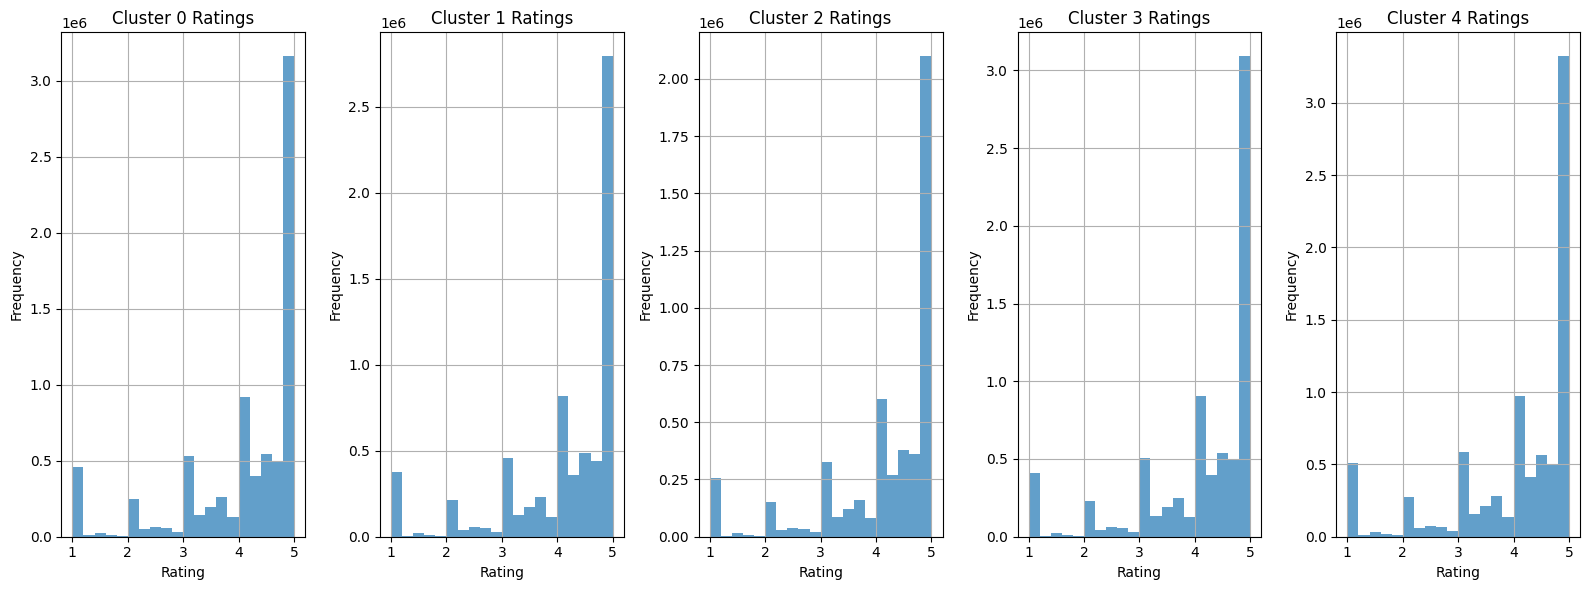

In [10]:
# 4. Rating distribution within each cluster
plt.figure(figsize=(16, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    product_df[product_df['cluster'] == i]['mean_rating'].hist(bins=20, alpha=0.7)
    plt.title(f'Cluster {i} Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Review distribution within each cluser

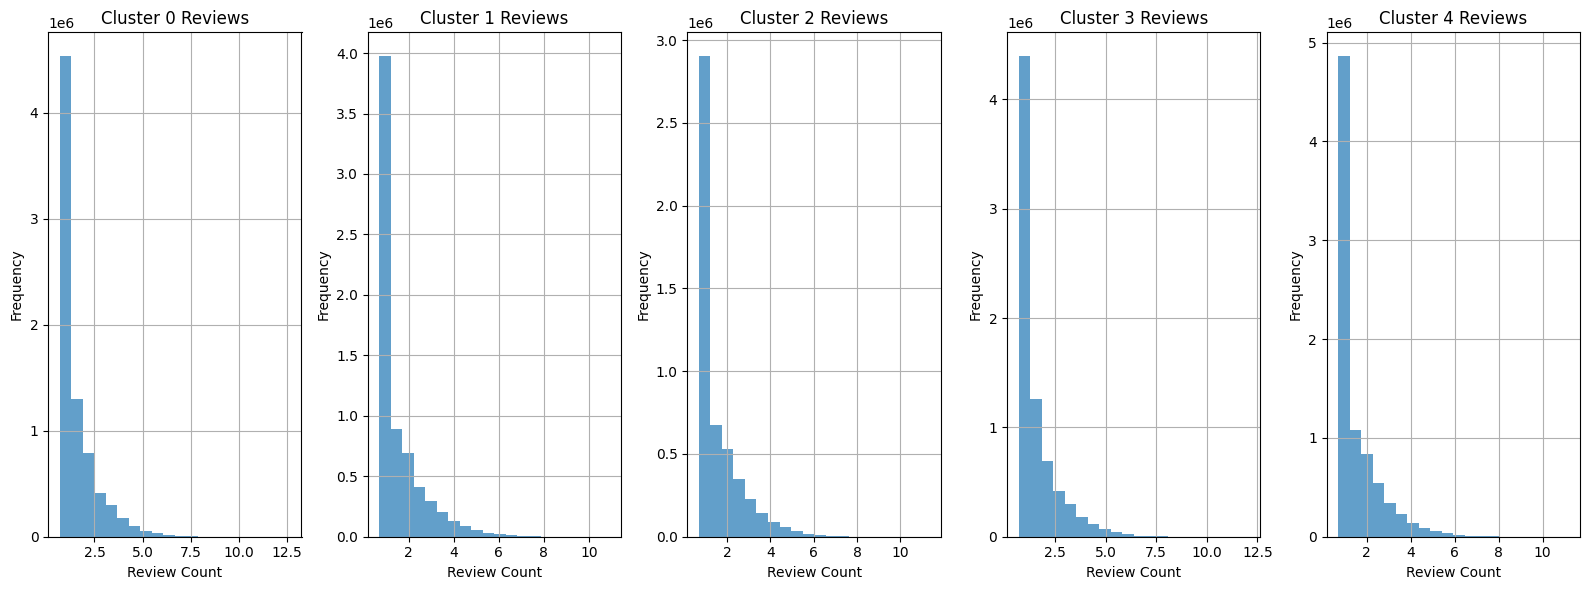

In [11]:
# Review count distribution within each cluster
plt.figure(figsize=(16, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    product_df[product_df['cluster'] == i]['total_reviews'].apply(np.log1p).hist(bins=20, alpha=0.7)
    plt.title(f'Cluster {i} Reviews')
    plt.xlabel('Review Count')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()